(week10:false_color_examples)=
# Landsat 8 false color examples

In the {ref}`week7:false_color` notebook we showed how to make a false color composite with Landsat 8 bands 5, 4, 3 mapped to 
red, blue and green (color infrared)

In this notebook we move that code into a function called `make_false_color`, and show a Vancouver scene with some different band combinations.  We make use of a boolean mask to get a stretched histogram using
skimage.exposure that only calculates the stretched histogram for cloud-free pixels over land.

The `make_false_color` function takes an [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) containing an fmask and all the Landsat bands
and returns a false color rioxarray.DataArray containing a [3,nrows,ncols] array with the stacked bands.

New functions:

- {ref}`make_dataset`
- {ref}`make_bool_mask`
- {ref}`make_false_color`

## Installation

1) Download [false_color_examples.ipynb](https://drive.google.com/drive/folders/1-Ja2wVKVIjkZb7Gx_rfc14J_aBYiknuw?usp=sharing) from the week 10 folder
2) Download the  week10 tif files from `satdata/landsat/vancouver_2023/week10` and move them to `~/repos/a301/satdata/landsat/week10/

In [1]:
import xarray
import rioxarray
from matplotlib import pyplot as plt
import numpy as np
from skimage import exposure, img_as_ubyte
from IPython.display import Image
from pathlib import Path
from numpy.typing import NDArray

## Understanding Landsat band location

The figure below shows average reflectances for various surface types. Compare some of thse
reflectance values with the landsat band locations in microns

1) coastal aerosol: 0.44
2) blue: 0.47
3) green: 0.55
4) red:  0.65
5) near-ir:  0.86
6) swir1  1.6
7) swir2: 2.2

```{figure} figures/hou_reflectance.png
:name: fig:reflectance_spectra
:width: 80%

Reflectance spectra
```

## Landsat bands by surface type

```{figure} figures/landsat8_bands.png
:name: landsat_8_bands![landsat8_bands.png](attachment:9454ecea-8cba-488a-87ec-110fb2b5d57f.png)
:width: 80%

Landsat 8 band wavelengths
```

## Landsat false color combinations

```{figure} figures/arc_gis_bands.png
:width: 80%
:name: landsat_8_bands


```

### Specific examples

- see [this website](https://www.nv5geospatialsoftware.com/Learn/Blogs/Blog-Details/the-many-band-combinations-of-landsat-8) for images that demonstrate the combinations
- see [this goes2go demo](https://blaylockbk.github.io/goes2go/_build/html/user_guide/notebooks/DEMO_rgb_recipes.html) for mulitple GOES band combinations

## False color bands for Vancouver

In [2]:
bands={'B01':'Coastal_Aerosol',
        'B02':'Blue',
        'B03':'Green',
        'B04':'Red',
        'B05':'NIR',
        'B06':'SWIR1',
        'B07':'SWIR2',
        'B09':'Cirrus',
        'B10':'TIRS1',
        'B11':'TIRS2',
        'fmask':'fmask'}

### Read all bands into a dictionary

Use the `bands` dictionary to identify the band by its name (Blue, Green, etc)
and store it in `scene_dict`.  Masking fmask would convert it from 8 bit to float, so we
need to special-case the fmask file.

In [3]:
data_dir = Path().home() / 'repos/a301/satdata/landsat'
all_tifs = list(data_dir.glob('**/week10*clipped_*.tif'))
scene_dict = {}
for key,bandname in bands.items():
    band_tif = None
    for the_tif in all_tifs:
        if str(the_tif).find(bandname) > -1:
            print(f"reading {key}:{the_tif}")
            if key == 'fmask':
                scene_dict[key] = rioxarray.open_rasterio(the_tif)
            else:
                scene_dict[key] = rioxarray.open_rasterio(the_tif, mask_and_scale=True)
            continue
   
    

reading B01:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Coastal_Aerosol.tif
reading B02:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Blue.tif
reading B03:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Green.tif
reading B04:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Red.tif
reading B05:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_NIR.tif
reading B06:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_SWIR1.tif
reading B07:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_SWIR2.tif
reading B09:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_Cirrus.tif
reading B10:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_TIRS1.tif
reading B11:/Users/phil/repos/a301/satdata/landsat/vancouver_2023/week10/week10_clipped_TIRS2.tif
reading fmask:

### Create an xarray dataset from the band dictionary

(make_dataset)=
#### make_dataset function

In [4]:
def make_dataset(
      scene_dict: dict)-> xarray.Dataset:
    """
    given a dictionary with landsat bands stored as rioxarray, keyed by
    the band name, return an rioxarray dataset containing all the bands
    plus metadata

    Parameters
    ----------

    scene_dict: dictionary with keys like 'B03'

    Returns
    -------

    ds_allbands: xarray dataset with all bands from the dictionary stored as variables
    
    """
    the_keys=list(scene_dict.keys())
    first_band=the_keys[0]
    ds_allbands = xarray.Dataset(data_vars=scene_dict,
               coords=scene_dict[first_band].coords,attrs=scene_dict[first_band].attrs)
    return ds_allbands

In [5]:
ds_allbands = make_dataset(scene_dict)

In [6]:
ds_allbands

<xarray.Dataset> Size: 10MB
Dimensions:      (band: 1, x: 400, y: 600)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 4.761e+05 4.761e+05 ... 4.881e+05 4.881e+05
  * y            (y) float64 5kB 5.465e+06 5.465e+06 ... 5.448e+06 5.447e+06
    spatial_ref  int64 8B 0
Data variables:
    B01          (band, y, x) float32 960kB ...
    B02          (band, y, x) float32 960kB ...
    B03          (band, y, x) float32 960kB ...
    B04          (band, y, x) float32 960kB ...
    B05          (band, y, x) float32 960kB ...
    B06          (band, y, x) float32 960kB ...
    B07          (band, y, x) float32 960kB ...
    B09          (band, y, x) float32 960kB ...
    B10          (band, y, x) float32 960kB ...
    B11          (band, y, x) float32 960kB ...
    fmask        (band, y, x) uint8 240kB ...
Attributes: (12/34)
    ACCODE:                    Lasrc; Lasrc
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    arop_rmse(meters):         0, 0
    arop_s2_refimg:            NONE
    ...                        ...
    TIRS_SSM_MODEL:            FINAL; FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED; ESTIMATED
    ULX:                       476100.0
    ULY:                       5465460.0
    USGS_SOFTWARE:             LPGS_16.3.0
    AREA_OR_POINT:             Area

(make_bool_mask)=
### make_bool_mask function

In [7]:
def make_bool_mask(
      da_fmask:xarray.DataArray
     ) -> NDArray[np.uint8]:
    """'
    turn a Landsat fmask into a boolean 1/0 array where
    cloud-free land pixels are 1 and all other pixels are 0
    For use by skimage.exposure.equalize_hist

    Parameters
    ----------

    da_fmask: the fmask DataArray

    Returns: bool_mask with the same shape
    """
    scene_mask = da_fmask.data
    mask_select =  0b00100011  #find water (bit 5), cloud (bit 1) , cirrus (bit 0)
    ref_mask = np.zeros_like(scene_mask)
    ref_mask[...] = mask_select
    print(type(scene_mask.dtype),type(ref_mask.dtype))
    masked_values = np.bitwise_and(scene_mask,ref_mask)
    masked_values[masked_values>0]=1  #cloud or water
    masked_values[masked_values==0]=0 #rest of scene
    #
    # now invert this, writing 1 for 0 and 0 for 1
    # use 9 as a placeholder value
    bool_mask = masked_values[...]
    bool_mask[masked_values==1] = 9
    bool_mask[masked_values==0] = 1
    bool_mask[masked_values==9] = 0
    return bool_mask
    
    
    
    

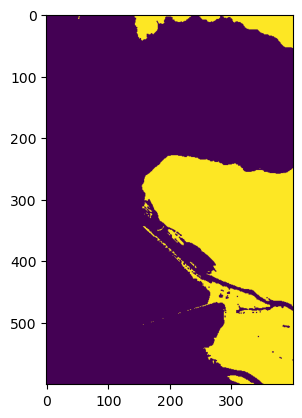

In [8]:
bool_image = make_bool_mask(scene_dict['fmask'])
plt.imshow(bool_image.squeeze())

(make_false_color)=
### make_false_color function

In [9]:
def make_false_color(
        the_ds: xarray.Dataset,
        band_names: list[str]) -> xarray.DataArray:
    """
    given a landsat dataset created with at least an fmask and 3 bands,
    return a histogram-equalized false color image with rgb mapped
    to the bands in the order they appear in the list band_names

    example usage:

    landsat_654 = make_false_color(the_ds,['B06','B05','B04'])

    Parameters
    ----------

    the_ds:
       created by make_dataset -- must contain at least 3 bands and Fmask
    band_names: 
       list of strings with the names of the bands to be mapped to red, green and blue

    Returns
    -------

    false_color: rioxarray with shape [3,nrows,ncols] that can be converted to png
    """
    the_ds = the_ds.squeeze()
    rgb_names = ["band_red", "band_green", "band_blue"]
    #
    # dictionary to hold the 3 rgb bands
    #
    scene_dict = dict()
    for the_rgb, the_band in zip(rgb_names, band_names):
        # print(f"{the_rgb=}, {the_band=}")
        scene_dict[the_rgb] = the_ds[the_band]
    crs = the_ds.rio.crs
    transform = the_ds.rio.transform()
    fmask = the_ds["fmask"].data
    bool_mask = make_bool_mask(fmask)
    #
    # histogram equalize the 3 bands
    #
    for key, image in scene_dict.items():
        scene_dict[key] = exposure.equalize_hist(image.data, mask=bool_mask)
    nrows, ncols = bool_mask.shape
    band_values = np.empty([3, nrows, ncols], dtype=np.uint8)
    #
    # convert to 0-255
    #
    for index, key in enumerate(rgb_names):
        stretched = scene_dict[key]
        band_values[index, :, :] = img_as_ubyte(stretched)
    #
    # only keep a subset of the attributes
    #
    keep_attrs = ["cloud_cover", "date", "day", "target_lat", "target_lon"]
    all_attrs = the_ds.attrs
    attr_dict = {key: value for key, value in all_attrs.items() if key in keep_attrs}
    attr_dict["history"] = "written by make_false_color"
    attr_dict["landsat_rgb_bands"] = band_names
    band_nums = [int(item[-1]) for item in band_names]
    coords = {"band": band_nums, "y": the_ds["y"], "x": the_ds["x"]}
    dims = ["band", "y", "x"]
    # print(f"{dims=}")
    # print(f"{band_values.shape=}")
    false_color = xarray.DataArray(
        band_values, coords=coords, dims=dims, attrs=attr_dict
    )
    false_color.rio.write_crs(crs, inplace=True)
    false_color.rio.write_transform(transform, inplace=True)
    return false_color

## True color (red, green, blue)

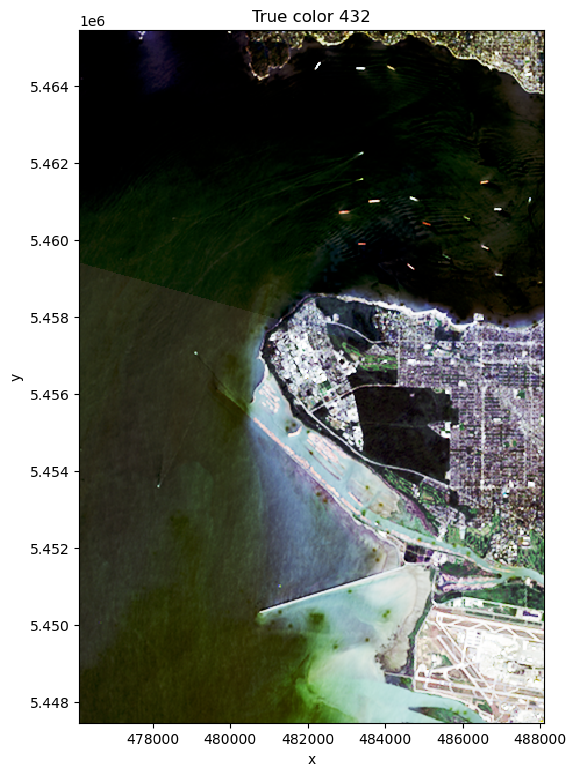

In [10]:
true_color = make_false_color(ds_allbands, band_names=["B04","B03","B02"])
fig1, ax1 = plt.subplots(1,1,figsize=(6,9))
true_color.plot.imshow(ax=ax1);
ax1.set(title="True color 432");

## Color infrared: near-ir, red, green

Add the 5-4 red edge for vegetation, plus green (also vegetation). See [band543 detail](https://eos.com/make-an-analysis/color-infrared/)

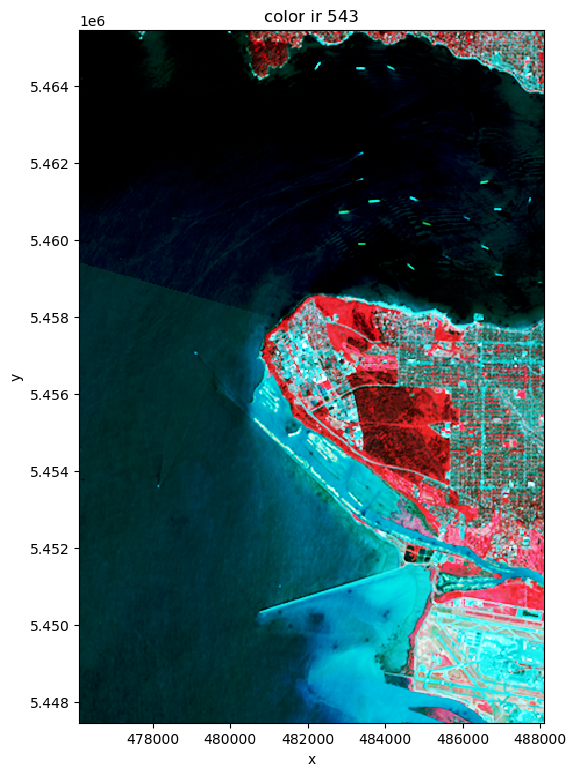

In [11]:
color_ir = make_false_color(ds_allbands, band_names=["B05","B04","B03"])
fig2, ax2 = plt.subplots(1,1,figsize=(6,9))
color_ir.plot.imshow(ax=ax2);
ax2.set(title="color ir 543");

## Vegetation swir-1, near-ir, red

Add swir-1 for moisture content, keep the 5-4 red edge. Less contrast for turbid/fresh water.  See [band654 detail](https://eos.com/make-an-analysis/vegetation-analysis/)

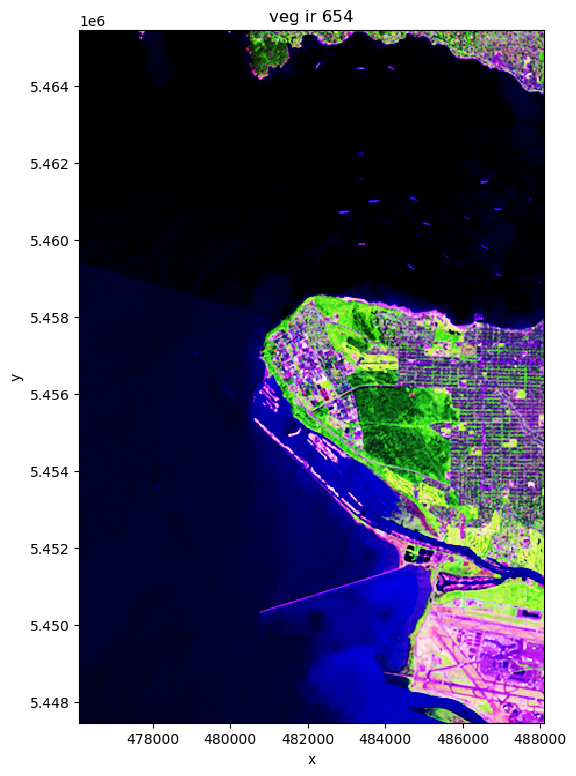

In [12]:
veg_ir = make_false_color(ds_allbands, band_names=["B06","B05","B04"])
fig3, ax3 = plt.subplots(1,1,figsize=(6,9))
veg_ir.plot.imshow(ax=ax3);
ax3.set(title="veg ir 654");

## Agriculture swir-1, near-ir, blue

Swap out red for blue.  See [band652 detail](https://eos.com/make-an-analysis/agriculture-band/)

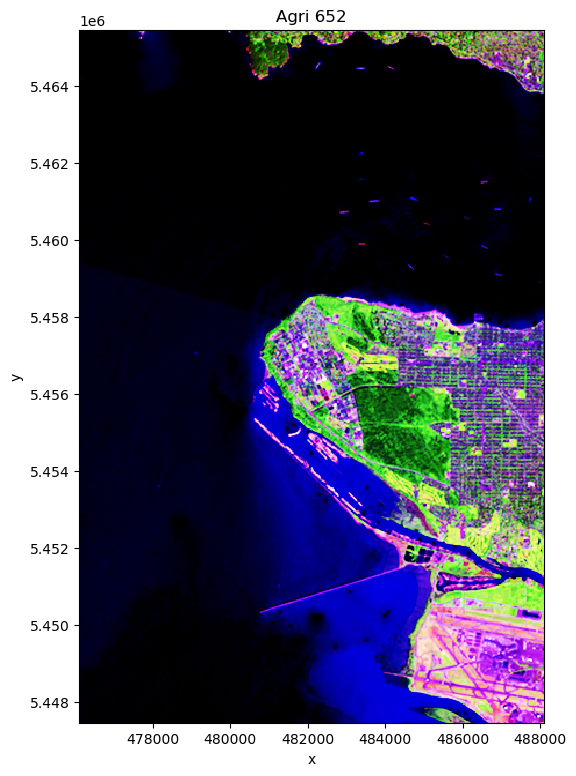

In [13]:
agri = make_false_color(ds_allbands, band_names=["B06","B05","B02"])
fig4, ax4 = plt.subplots(1,1,figsize=(6,9))
agri.plot.imshow(ax=ax4);
ax4.set(title="Agri 652");

## Urban swir-2, swir-1, red

concrete and bare soil have approximately constant reflectivities between 1.6 and 2.2 microns,
while vegetation reflects more in swir-1 than swir-2.  This combination distinguishes between
types of urban development.  Less contrast for turbid/fresh water.  See: [band764 detail](https://eos.com/make-an-analysis/shortwave-infrared/)

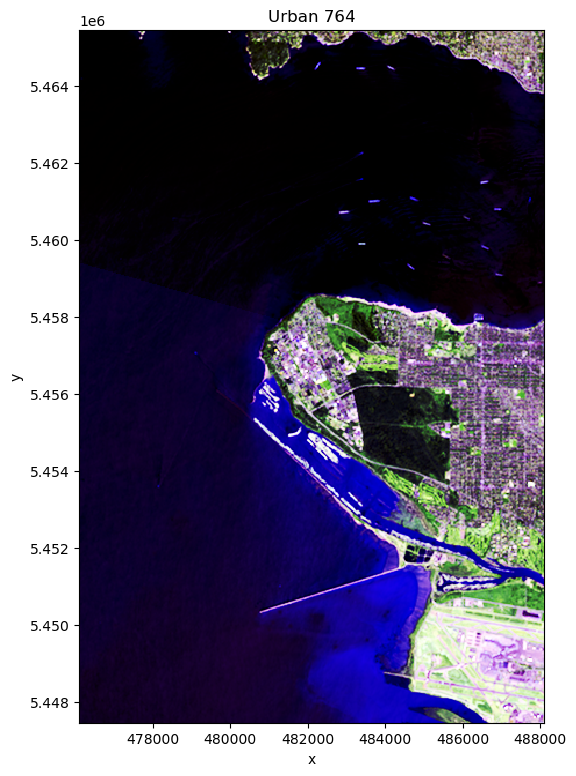

In [14]:
urban = make_false_color(ds_allbands, band_names=["B07","B06","B04"])
fig5, ax5 = plt.subplots(1,1,figsize=(6,9))
urban.plot.imshow(ax=ax5);
ax5.set(title="Urban 764");